<a href="https://www.kaggle.com/samu2505/bacteria-dna-classification?scriptVersionId=89213065" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2022/train.csv
/kaggle/input/tabular-playground-series-feb-2022/test.csv


In [2]:
# I'll be starting with tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_csv("../input/tabular-playground-series-feb-2022/train.csv", index_col=0)
test = pd.read_csv("../input/tabular-playground-series-feb-2022/test.csv", index_col=0)

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

Training data shape:  (200000, 287)
Test data shape:  (100000, 286)


In [4]:
# checking available data types
print("Data types:\n", train.dtypes.unique())

# checking for missing data
print("\nMissing data in train set:\n", np.sum(train.isna().sum()))
print("\nMissing data in test set:\n", np.sum(test.isna().sum()))

# checking for duplicate values
print("\nDuplicate values in train set:\n", train.duplicated().sum())
print("\nDuplicate values in test set:\n", test.duplicated().sum())

Data types:
 [dtype('float64') dtype('O')]

Missing data in train set:
 0

Missing data in test set:
 0

Duplicate values in train set:
 76007

Duplicate values in test set:
 26779


In [5]:
# Now, have to deal with duplicate values in the dataset
train_with_duplicates = train.copy()

# drop the duplicate values out of the dataset for both the train and test sets
train.drop_duplicates(keep='first', inplace=True)
# Dont't temper with the test set.
# test.drop_duplicates(keep='first', inplace=True)

print("Shape of new training data: ", train.shape)
print("Checking number of duplicates in new training data: ", train.duplicated().sum())

Shape of new training data:  (123993, 287)
Checking number of duplicates in new training data:  0


In [6]:
# CHECKING FOR THE DISTRIBUTION OF THE TARGETS FOR BOTH CASES
def plot(train, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xticks(rotation=30, ha='right')
    ax = sns.countplot(x=train['target'], data=train)
    print(pd.Series(train['target'], index=train.index).value_counts().sort_index() / len(train) * 100)
    plt.show()

Bacteroides_fragilis        10.098957
Campylobacter_jejuni        10.056213
Enterococcus_hirae           9.978789
Escherichia_coli             9.917495
Escherichia_fergusonii       9.907817
Klebsiella_pneumoniae       10.016694
Salmonella_enterica          9.992500
Staphylococcus_aureus       10.012662
Streptococcus_pneumoniae    10.013469
Streptococcus_pyogenes      10.005404
Name: target, dtype: float64


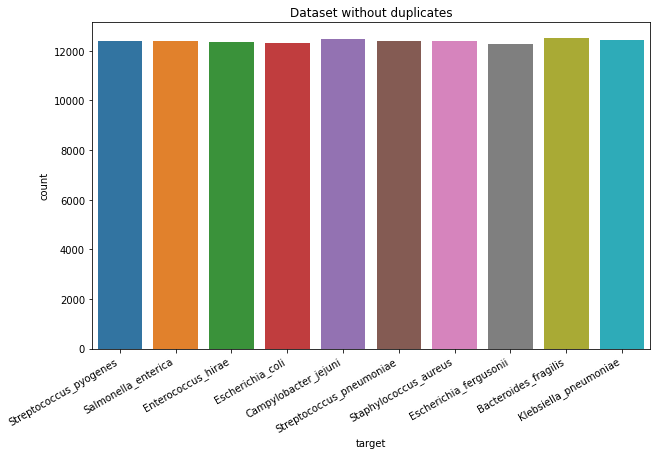

In [7]:
plot(train, "Dataset without duplicates")

Bacteroides_fragilis        10.0695
Campylobacter_jejuni        10.0315
Enterococcus_hirae           9.9735
Escherichia_coli             9.9790
Escherichia_fergusonii       9.9685
Klebsiella_pneumoniae        9.9235
Salmonella_enterica         10.0150
Staphylococcus_aureus        9.9645
Streptococcus_pneumoniae    10.0370
Streptococcus_pyogenes      10.0380
Name: target, dtype: float64


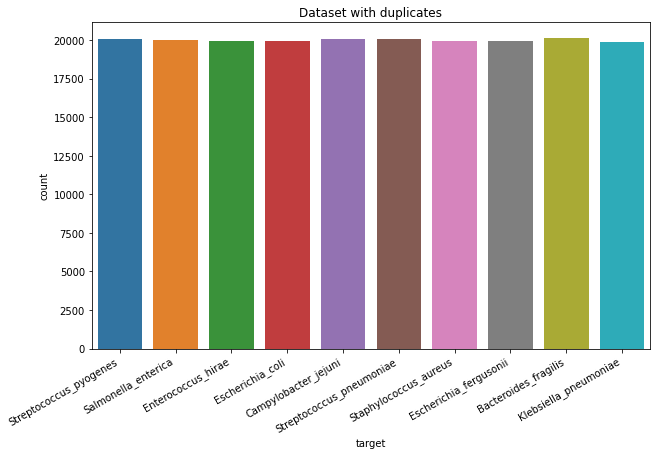

In [8]:
plot(train_with_duplicates, "Dataset with duplicates")

In [9]:
# Next, checking for memory usage 
# print("Memory usage(train_with_duplicates): {:5.2f} Mb".format(train_with_duplicates.memory_usage().sum()/1024**2))
# print("Memory usage(train): {:5.2f} Mb".format(train.memory_usage().sum()/1024**2))

# Still, the memory usage can be reduced further
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
    initial_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_dtype = df[col].dtypes
        
        if col_dtype in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_dtype)[:3] == 'int':  
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum()/1024**2
    if verbose:
        print("Mem usage decreased to {:5.2f} Mb, ({:4.2f}%)".format(end_mem, 100*(initial_mem - end_mem)/initial_mem))
    return df

In [10]:
# Reducing memory usage for the dataset without duplicates
print("New memory usage for train set")
train = reduce_mem_usage(train)

print("New memory usage for test set")
test = reduce_mem_usage(test)
# Reducing memory usage for the dataset with duplicates
# train_with_duplicates = reduce_mem_usage(train_with_duplicates)

New memory usage for train set
Mem usage decreased to 141.20 Mb, (48.93%)
New memory usage for test set
Mem usage decreased to 109.86 Mb, (49.83%)


In [11]:
# Now, we can separate the features from the targets
features = train.columns[:-1]
target = 'target'

print("# of features: ", len(features))

# of features:  286


In [12]:
# Target encoding, that is turn the bacteria into numeric labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train[target] = encoder.fit_transform(train[target])

# sample_weight = train.value_counts().values

In [13]:
# Preprocess the features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_with_duplicates[features])
scaled_data = pd.DataFrame(scaled_data, columns=features)

In [14]:
test = scaler.fit_transform(test)

In [15]:
scaled_data.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,-0.018438,-0.049055,-0.099841,-0.240396,-0.300284,-0.305733,-0.276749,-0.238137,-0.142872,-0.024116,...,-0.250392,-0.388083,-0.323410,-0.444488,-0.436241,-0.356999,-0.152918,-0.181456,-0.186407,-0.057325
1,-0.018438,-0.049055,-0.099841,2.055508,-0.300284,0.844497,-0.276749,-0.238137,-0.142872,-0.024116,...,-0.250392,-0.388083,-0.323410,0.363383,0.218321,-0.356999,-0.152918,-0.181456,-0.186407,-0.057325
2,-0.018438,0.011693,0.074608,0.317508,0.384633,0.280884,0.294624,0.304069,0.268421,0.011929,...,-0.130892,-0.235909,-0.223794,-0.309574,-0.310565,-0.259742,-0.109998,-0.148583,-0.143687,0.040232
3,-0.006884,-0.018681,0.092053,0.583833,0.712456,0.570742,0.491960,0.467411,0.231031,0.011929,...,-0.094339,-0.175934,-0.166871,-0.229594,-0.247727,-0.191240,-0.086392,-0.135799,-0.103912,-0.057325
4,-0.018438,-0.049055,-0.099841,-0.240396,-0.300284,-0.305733,-0.276749,-0.238137,-0.142872,-0.024116,...,-0.250392,-0.388083,-0.323410,-0.444488,-0.436241,-0.356999,-0.152918,-0.181456,-0.186407,-0.057325


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [17]:
scaled_data['target'] = train_with_duplicates[target]

In [18]:
def ExtraTreesModel(N_ESTIMATORS=1000):
    model = ExtraTreesClassifier(
        n_estimators=N_ESTIMATORS,
        n_jobs=-1,
        verbose=0,
        random_state=1221
    )
    return model

def DNN():
    inputs = keras.Input(shape=X.shape[1])
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [19]:
scaled_data[target] = encoder.fit_transform(scaled_data[target])

In [20]:
# N_SPLITS = 10
# X, y = scaled_data[features], scaled_data[target]
# folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=1334)
# dnn_preds = []
# for fold, (train_id, valid_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):
#     x_tr = X.iloc[train_id]
#     y_tr = y.iloc[train_id]
#     x_val = X.iloc[valid_id]
#     y_val = y.iloc[valid_id]
#     y_tr = keras.utils.to_categorical(y_tr)
#     y_val = keras.utils.to_categorical(y_val)
#     model = DNN()
#     callbacks = [
#         keras.callbacks.EarlyStopping(
#             monitor='val_loss', patience=10, verbose=1
#         )
#     ]
#     model.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])
#     model.fit(x_tr, y_tr, validation_data=(x_val, y_val), batch_size=128, epochs=50, callbacks=callbacks, verbose=0)
#     print(f"Fold {fold} Evaluation: {model.evaluate(x_val, y_val)}")
#     dnn_preds.append(model.predict(test))

In [21]:
def training_loop(data, model_name = "etc", N_SPLITS=10):
    X = data[features]
    # hard coded (:
    y = train_with_duplicates[target]
    sample_weight = data.value_counts().values
    folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=1223)
    scores = []
    predictions = []

    for fold, (train_id, valid_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):
        X_train = X.iloc[train_id]
        y_train = y.iloc[train_id]
        X_valid = X.iloc[valid_id]
        y_valid = y.iloc[valid_id]

        if model_name == "etc":
            # etc stands for ExtraTreeClassifier
            # Training
            model = ExtraTreesModel()
            if len(sample_weight) == 0:
                model.fit(X_train, y_train)
            else:
#                  sample_weight_train = sample_weight[train_id]
                model.fit(X_train, y_train)
            
#             validation
            valid_pred = model.predict(X_valid)
            valid_score = 0
            if len(sample_weight) == 0:
                valid_score = accuracy_score(valid_pred, y_valid)
            else:
#                 sample_weight_valid = sample_weight[valid_id]
                valid_score = accuracy_score(valid_pred, y_valid)
                scores.append(valid_score)
            print(f"Fold {fold+1} \tAccuracy: {valid_score:.4f}")
        
        predictions.append(model.predict_proba(test))
    
    return {"model": model, "logits": predictions}

In [22]:
etc_model = training_loop(data=scaled_data, N_SPLITS=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Fold 1 	Accuracy: 0.9935
Fold 2 	Accuracy: 0.9937
Fold 3 	Accuracy: 0.9934


In [23]:
# Neural network outputs are probabilistic. 
# Doing the same for the ExtraTreeClassifier
# dnn_probas = dnn_model.predict(test)
# etc_probas = etc_model.predict_proba(test)
model = etc_model['model']
logits = etc_model['logits']

logits = sum(logits)/len(logits)
# dnn_preds = sum(dnn_preds)/len(dnn_preds)

# preds = 0.9*logits + 0.1*dnn_preds

predictions = pd.DataFrame({'predictions': np.argmax(logits, axis=1)})
predictions.to_csv('Predictions.csv')

In [24]:
predictions = pd.read_csv("Predictions.csv", index_col=0)
predictions.head()

,predictions
0,4
1,6
2,2
3,6
4,7


In [25]:
# convert the numbers into the respective names of the bacteria
labels = encoder.inverse_transform(predictions)
labels

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array(['Escherichia_fergusonii', 'Salmonella_enterica',
       'Enterococcus_hirae', ..., 'Bacteroides_fragilis',
       'Bacteroides_fragilis', 'Streptococcus_pyogenes'], dtype=object)

In [26]:
sample = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

In [27]:
sample['target'] = labels
sample.to_csv("submission.csv", index=False)

In [28]:
pd.read_csv("submission.csv").head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus
